### Import Libraries

In [27]:
from keras.metrics import categorical_accuracy
from keras.models import Sequential
import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed
from keras.regularizers import L1L2
from keras.utils import to_categorical
from keras.initializers import lecun_uniform
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Test_Training

ModuleNotFoundError: No module named 'google.colab'

## Loading Data

In [28]:
def data_prep(X,y,sub_sample,average,noise,time):

    total_X = None
    total_y = None

    # # Trimming the data (sample,22,1000) -> (sample,22,500)
    # X = X[:,:,0:time]
    # print('Shape of X after trimming:',X.shape)

    # # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    # X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    # total_X = X_max
    # total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    # X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X + np.random.normal(0.0, 0.5, X.shape)

    total_X =  X_average
    total_y =  y

    # total_X = np.vstack((total_X, X_average))
    # total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    # for i in range(sub_sample):

    #     X_subsample = X[:, :, i::sub_sample] + \
    #                         (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

    #     total_X = np.vstack((total_X, X_subsample))
    #     total_y = np.hstack((total_y, y))


    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [37]:
def load_data(time, debug=True, onehot=False, time_bin=True):

## Loading the dataset
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769

    print(X_train_valid.shape)
    print(y_train_valid.shape)
    print(X_test.shape)
    print(y_test.shape)
    print (person_train_valid.shape)
    print (person_test.shape)

    ## Preprocessing dataset
    if not time_bin:
      X_train_valid,y_train_valid = data_prep(X_train_valid,y_train_valid,2,2,True,time)

    if debug:
        print('Shape of training/validation set:',X_train_valid.shape)
        print('Shape of training/validation labels:',y_train_valid.shape)
        print('Shape of testing set:',X_test.shape)
        print('Shape of testing labels:',y_test.shape)


    if onehot:
        # Converting the labels to categorical variables for multiclass classification
        y_train_valid = to_categorical(y_train_valid, 4)
        y_test = to_categorical(y_test, 4)
        if debug:
            print('Shape of training/valid labels after categorical conversion:',y_train_valid.shape)
            print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    X_train_valid = X_train_valid.reshape(X_train_valid.shape[0], X_train_valid.shape[1], X_train_valid.shape[2], 1)
    x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    if debug:
        print('Shape of training set after adding width info:',X_train_valid.shape)
        print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    # x_train = np.swapaxes(x_train, 1,3)
    # x_train = np.swapaxes(x_train, 1,2)
    # x_valid = np.swapaxes(x_valid, 1,3)
    # x_valid = np.swapaxes(x_valid, 1,2)
    # x_test = np.swapaxes(x_test, 1,3)
    # x_test = np.swapaxes(x_test, 1,2)
    # if debug:
    #     print('Shape of training set after dimension reshaping:',x_train.shape)
    #     print('Shape of validation set after dimension reshaping:',x_valid.shape)
    #     print('Shape of test set after dimension reshaping:',x_test.shape)

    return X_train_valid, y_train_valid, x_test, y_test, person_test, person_train_valid

In [49]:
time = 500
## Preprocessing the dataset

x_train_valid, y_train_valid, x_test, y_test, person_test, person_train_valid = load_data(time=time, onehot=True, time_bin=False)

(2115, 22, 1000)
(2115,)
(443, 22, 1000)
(443,)
(2115, 1)
(443, 1)
Shape of X after averaging+noise and concatenating: (2115, 22, 1000)
Shape of training/validation set: (2115, 22, 1000)
Shape of training/validation labels: (2115,)
Shape of testing set: (443, 22, 1000)
Shape of testing labels: (443,)
Shape of training/valid labels after categorical conversion: (2115, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (2115, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)


## Model

In [62]:
def cnn_rnn_lstm_less_than_300(kernel_initializer, time_period=300):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(32, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    model.add(Permute((2, 3, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(CuDNNLSTM(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[categorical_accuracy])

    return model

In [65]:
def cnn_rnn_lstm_model(kernel_initializer, time_period=500):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(32, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    # model.add(Conv2D(128, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    # model.add(ELU())
    # model.add(BatchNormalization(axis=1))
    # model.add(MaxPool2D((1, 4)))
    # model.add(Dropout(0.4))

    model.add(Permute((2, 3, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(CuDNNLSTM(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.6))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=[categorical_accuracy])

    return model

## Training Data

In [66]:
def train(sub_idx=None, time_period=1000):
    # different period of time
    X_train_valid_cur = x_train_valid[:, :, :time_period]
    y_train_valid_cur = y_train_valid
    X_test_cur = x_test[:, :, :time_period]
    y_test_cur = y_test

    # single subject dataset
    if sub_idx is not None:
        X_train_valid_cur = X_train_valid_cur[np.where(person_train_valid == sub_idx)[0]]
        y_train_valid_cur = y_train_valid[np.where(person_train_valid == sub_idx)[0]]
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test[np.where(person_test == sub_idx)[0]]

    # Weight initialization
    lecun = lecun_uniform(seed=42)

    if time_period < 300:
        model = cnn_rnn_lstm_less_than_300(lecun, time_period)
    else:
        model = cnn_rnn_lstm_model(lecun, time_period)
    results = model.fit(X_train_valid_cur, y_train_valid_cur, epochs=30, batch_size=64, validation_data=(X_test_cur, y_test_cur), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_valid_cur, y_train_valid_cur)
    test_score = model.evaluate(X_test_cur, y_test_cur)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    print(model.summary())

    return results, train_score, test_score, model

##All Subjects

In [67]:
results, train_score, test_score, model = train(time_period=500)

Epoch 1/30


2024-03-15 21:02:00.852010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 2.0440 - categorical_accuracy: 0.2889

2024-03-15 21:02:17.506623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 21s 483ms/step - loss: 2.0440 - categorical_accuracy: 0.2889 - val_loss: 1.8871 - val_categorical_accuracy: 0.3002
Epoch 2/30
34/34 [==============================] - 6s 177ms/step - loss: 1.7797 - categorical_accuracy: 0.3513 - val_loss: 1.6967 - val_categorical_accuracy: 0.3228
Epoch 3/30
34/34 [==============================] - 7s 198ms/step - loss: 1.6083 - categorical_accuracy: 0.3749 - val_loss: 1.5261 - val_categorical_accuracy: 0.4153
Epoch 4/30
34/34 [==============================] - 10s 305ms/step - loss: 1.4726 - categorical_accuracy: 0.4478 - val_loss: 1.4202 - val_categorical_accuracy: 0.4537
Epoch 5/30
34/34 [==============================] - 6s 175ms/step - loss: 1.3873 - categorical_accuracy: 0.4804 - val_loss: 1.3963 - val_categorical_accuracy: 0.4786
Epoch 6/30
34/34 [==============================] - 6s 182ms/step - loss: 1.3702 - categorical_accuracy: 0.4771 - val_loss: 1.3591 - val_categorical_accuracy: 0.4831
Epoch 7/30
34

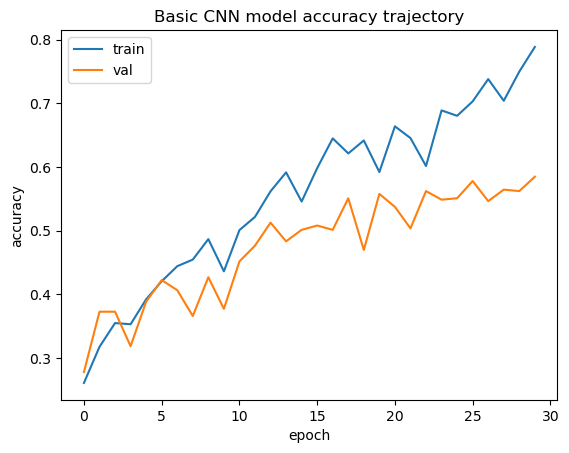

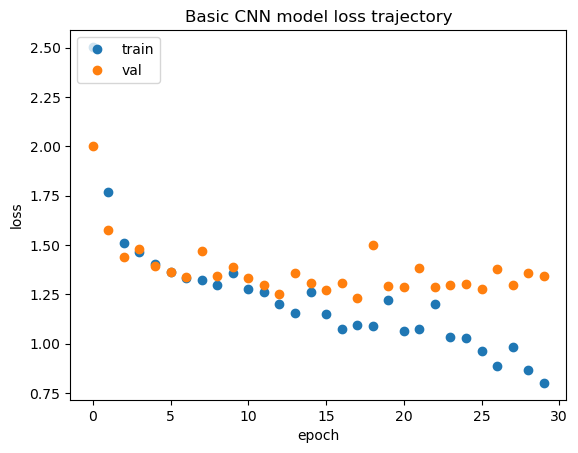

In [60]:
# Plotting accuracy trajectory
plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(results.history['loss'],'o')
plt.plot(results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Single Subject of Data

In [55]:
def test_single(model, sub_idx=None, time_period=1000):
    X_test_cur = x_test[:, :, :time_period]
    y_test_cur = y_test

    if sub_idx is not None:
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test[np.where(person_test == sub_idx)[0]]

    test_score = model.evaluate(X_test_cur, y_test_cur)

    return test_score


In [56]:
test_single_score = test_single(model, sub_idx = 0)
print('Test accuracy of the basic CNN model on Subject 0:',test_single_score[1])

2024-03-15 17:48:13.311226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 641ms/step - loss: 2.7129 - categorical_accuracy: 0.5000
Test accuracy of the basic CNN model on Subject 0: 0.5


##Function of Time

In [47]:
train_scores = []
test_scores = []

for time in range(250, 1001, 250):
    print("=================" + str(time) + "===================")
    results, train_score, test_score, model = train(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)
max_idx = np.argmax(test_scores)
print("The best accuracy is %.3f." %max(test_scores))
print("The corresponding time period is %d." %(250 + 250 * max_idx))

# plot


=================250===================
Epoch 1/40


2024-03-15 13:32:31.870450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 1.9329 - categorical_accuracy: 0.2889

2024-03-15 13:32:44.465646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 16s 174ms/step - loss: 1.9329 - categorical_accuracy: 0.2889 - val_loss: 1.7249 - val_categorical_accuracy: 0.2686
Epoch 2/40
67/67 [==============================] - 7s 109ms/step - loss: 1.6135 - categorical_accuracy: 0.3092 - val_loss: 1.5083 - val_categorical_accuracy: 0.3183
Epoch 3/40
67/67 [==============================] - 7s 103ms/step - loss: 1.4648 - categorical_accuracy: 0.3489 - val_loss: 1.4253 - val_categorical_accuracy: 0.3634
Epoch 4/40
67/67 [==============================] - 7s 103ms/step - loss: 1.3752 - categorical_accuracy: 0.4227 - val_loss: 1.3763 - val_categorical_accuracy: 0.4176
Epoch 5/40
67/67 [==============================] - 8s 113ms/step - loss: 1.3502 - categorical_accuracy: 0.4340 - val_loss: 1.3854 - val_categorical_accuracy: 0.4221
Epoch 6/40
67/67 [==============================] - 7s 101ms/step - loss: 1.3249 - categorical_accuracy: 0.4591 - val_loss: 1.3020 - val_categorical_accuracy: 0.4650
Epoch 7/40
67/

2024-03-15 13:37:35.998230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 2.1804 - categorical_accuracy: 0.2913

2024-03-15 13:37:52.566628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 20s 237ms/step - loss: 2.1804 - categorical_accuracy: 0.2913 - val_loss: 1.6387 - val_categorical_accuracy: 0.3093
Epoch 2/40
67/67 [==============================] - 9s 135ms/step - loss: 1.5172 - categorical_accuracy: 0.3485 - val_loss: 1.4375 - val_categorical_accuracy: 0.3950
Epoch 3/40
67/67 [==============================] - 9s 140ms/step - loss: 1.4076 - categorical_accuracy: 0.4038 - val_loss: 1.3907 - val_categorical_accuracy: 0.3792
Epoch 4/40
67/67 [==============================] - 9s 128ms/step - loss: 1.3614 - categorical_accuracy: 0.4270 - val_loss: 1.4581 - val_categorical_accuracy: 0.3544
Epoch 5/40
67/67 [==============================] - 9s 132ms/step - loss: 1.3507 - categorical_accuracy: 0.4303 - val_loss: 1.3600 - val_categorical_accuracy: 0.4086
Epoch 6/40
67/67 [==============================] - 9s 132ms/step - loss: 1.3283 - categorical_accuracy: 0.4463 - val_loss: 1.3485 - val_categorical_accuracy: 0.4199
Epoch 7/40
67/

2024-03-15 13:43:49.371893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 2.3054 - categorical_accuracy: 0.2704

2024-03-15 13:44:11.233960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 26s 313ms/step - loss: 2.3054 - categorical_accuracy: 0.2704 - val_loss: 1.8102 - val_categorical_accuracy: 0.2619
Epoch 2/40
67/67 [==============================] - 10s 149ms/step - loss: 1.5938 - categorical_accuracy: 0.3220 - val_loss: 1.5177 - val_categorical_accuracy: 0.2822
Epoch 3/40
67/67 [==============================] - 11s 157ms/step - loss: 1.4441 - categorical_accuracy: 0.3598 - val_loss: 1.3988 - val_categorical_accuracy: 0.3499
Epoch 4/40
67/67 [==============================] - 10s 156ms/step - loss: 1.3709 - categorical_accuracy: 0.4184 - val_loss: 1.3846 - val_categorical_accuracy: 0.3792
Epoch 5/40
67/67 [==============================] - 10s 147ms/step - loss: 1.3284 - categorical_accuracy: 0.4600 - val_loss: 1.3969 - val_categorical_accuracy: 0.3950
Epoch 6/40
67/67 [==============================] - 10s 146ms/step - loss: 1.3056 - categorical_accuracy: 0.4761 - val_loss: 1.3215 - val_categorical_accuracy: 0.4605
Epoch 7/4

2024-03-15 13:51:08.726397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 2.3620 - categorical_accuracy: 0.2392

2024-03-15 13:51:26.772839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 23s 267ms/step - loss: 2.3620 - categorical_accuracy: 0.2392 - val_loss: 1.7809 - val_categorical_accuracy: 0.2686
Epoch 2/40
67/67 [==============================] - 13s 188ms/step - loss: 1.6119 - categorical_accuracy: 0.2709 - val_loss: 1.5314 - val_categorical_accuracy: 0.2867
Epoch 3/40
67/67 [==============================] - 11s 164ms/step - loss: 1.4712 - categorical_accuracy: 0.3092 - val_loss: 1.4194 - val_categorical_accuracy: 0.3815
Epoch 4/40
67/67 [==============================] - 11s 163ms/step - loss: 1.4039 - categorical_accuracy: 0.3574 - val_loss: 1.3852 - val_categorical_accuracy: 0.3634
Epoch 5/40
67/67 [==============================] - 13s 192ms/step - loss: 1.3957 - categorical_accuracy: 0.3877 - val_loss: 1.4365 - val_categorical_accuracy: 0.3499
Epoch 6/40
67/67 [==============================] - 12s 182ms/step - loss: 1.3594 - categorical_accuracy: 0.4047 - val_loss: 1.3416 - val_categorical_accuracy: 0.3995
Epoch 7/4

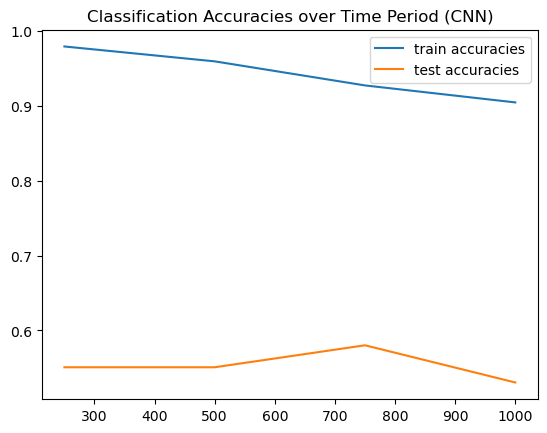

In [48]:
plt.plot(range(250, 1001, 250), train_scores, label='train accuracies')
plt.plot(range(250, 1001, 250), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()